## Part 2A: Discrete shape analysis

In this notebook, we will learn the basics of shape analysis on landmarked data.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

### 0. Data loading

**0.1** Run the lines below to load the object models dataset.

In [2]:
# BBBC010
directory='data/BBBC010/masks'
point_models=np.load(os.path.join(directory,'point_models.npy'))

In [3]:
# The number of points in our object model is an important parameter
N=point_models.shape[1]

**0.2** Visualize a set of a few randomly selected models from the collection.

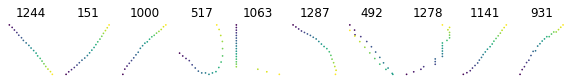

In [4]:
# Your turn!
number=10
inds=np.random.choice(len(point_models)-1, size=number, replace=False)

fig, ax = plt.subplots(1,number, figsize=(number,1))
for i in range(number):
    point_model=np.array(point_models[inds[i]])
    t=np.arange(N)
    ax[i].scatter(point_model[:,0],point_model[:,1],s=.5,c=t,cmap='viridis')
    ax[i].set_title(str(inds[i]))
    ax[i].axis('off')

### 1. Procrustes alignment

**1.1** Center and scale the data such that they are all located around (0,0) and are of unit norm.

In [5]:
# Your turn!
preshapes=np.zeros(point_models.shape)

for i in range(len(point_models)):
    point_model=point_models[i]
    
    centroid=np.mean(point_model,0)
    centered=point_model-centroid
    
    scaled=centered/np.linalg.norm(centered)
    preshapes[i]=scaled

**1.2** Write a function that aligns one object model onto another reference one, assuming that the models are in correspondence†.

This problem can be formulated as finding the optimal rotation angle such that the distance between the two point sets is minimal.

*Hint: use ``scipy.optimize`` to carry out the optimization*

† This assumption is not necessarily biologically correct in the present case. Do you understand why? What is missing from the data preparation pipeline for it to hold?

In [11]:
import scipy.optimize

In [ ]:
# Your turn!
# Pick two random models and try to align them
random=np.random.choice(len(point_models)-1, size=2, replace=False)
plt.scatter(preshapes[random[0]][:,0],preshapes[random[0]][:,1])
plt.scatter(preshapes[random[1]][:,0],preshapes[random[1]][:,1])
plt.axis('off')
plt.show()

In [6]:
# Define the objective function
def objectiveFunctionAlignment(theta, m1, m2):
    R=np.array([[np.cos(theta[0]),-np.sin(theta[0])],[np.sin(theta[0]),np.cos(theta[0])]])
    rotated_m2=R.dot(m2.T).T
    error=np.linalg.norm(m1-rotated_m2)
    rmse=np.sqrt(np.mean(error**2))
    return rmse

In [ ]:
# Optimize
res=scipy.optimize.minimize(objectiveFunctionAlignment,0,args=(preshapes[random[0]],preshapes[random[1]]),method="L-BFGS-B")
theta0=res.x[0]

In [ ]:
# Visualize the alignment
plt.scatter(preshapes[random[0]][:,0],preshapes[random[0]][:,1])

R=np.array([[np.cos(theta0),-np.sin(theta0)],[np.sin(theta0),np.cos(theta0)]])
aligned=R.dot(preshapes[random[1]].T).T

plt.scatter(aligned[:,0],aligned[:,1])
plt.axis('off')
plt.show()

### 2. Kendall shape space

**2.1** Each input shape can be seen as a vector of complex numbers and associated with an appropriate Hermitian inner product. The lines below transforms your aligned shape dataset into complex vectors. Convince yourself that the "vector of complex numbers" representation is equivalent to the "vector of points" one.

In [7]:
complex_preshapes=preshapes[:,:,0] + 1j*preshapes[:,:,1]

**2.2** The function below computes the Fréchet mean of a dataset relying on complex number representations. Use it to extract the Fréchet mean of your data and visualize it.

In [8]:
def meanFrechet(input_complex_preshapes): # preshapes
    '''Input: dataset of complex preshapes.
    Output: Fréchet mean (w.r.t. the Procrustes distance).'''
    SQ = input_complex_preshapes.T @ input_complex_preshapes.conj()
    D,V = np.linalg.eig(SQ)
    ds = np.real(D)
    ind_max = np.argmax(ds)
    ds_max = np.max(ds)
    m = V[:,ind_max]
    
    centered_m=m-np.mean(m)
    m_norm=np.sqrt(centered_m.conj().T @ centered_m).real
    return m/m_norm

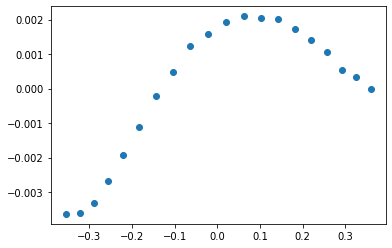

In [9]:
# Your turn!
mean_shape_Frechet=meanFrechet(complex_preshapes)
plt.scatter(mean_shape_Frechet.real,mean_shape_Frechet.imag)
plt.show()

**2.3** Using the pairwise alignment routine you wrote in 1.2, align the whole dataset onto the Fréchet mean.

In [12]:
# Your turn!
aligned_shapes=np.zeros(preshapes.shape)

reference=np.stack((mean_shape_Frechet.real,mean_shape_Frechet.imag),axis=1)
for i in range(len(preshapes)):
    res=scipy.optimize.minimize(objectiveFunctionAlignment,0,args=(reference,preshapes[i]),method="L-BFGS-B")
    theta0=res.x[0]
    R=np.array([[np.cos(theta0),-np.sin(theta0)],[np.sin(theta0),np.cos(theta0)]])
    aligned_shapes[i]=R.dot(preshapes[i].T).T

**2.4** Now that all shapes are aligned, compute the (point-by-point) mean shape of the dataset and visualize it. Does it differ from what you got in 2.2?

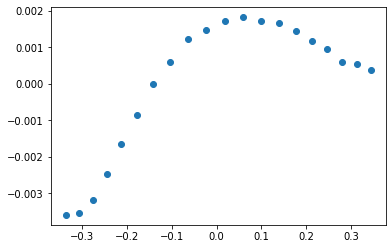

In [13]:
# Your turn!
mean_shape=np.mean(aligned_shapes,0)
plt.scatter(mean_shape[:,0],mean_shape[:,1])
plt.show()

**2.5** Repeat 2.3 and 2.4 by aligning the dataset onto an arbitrarily chosen shape from the collection (e.g., the first one). Does the mean shape differ from what you got in 2.4? 

In [ ]:
# Your turn!
# Align the whole dataset onto the first preshape
aligned_shapes_2=np.zeros(preshapes.shape)

reference=preshapes[0]
for i in range(len(preshapes)):
    res=scipy.optimize.minimize(objectiveFunctionAlignment,0,args=(reference,preshapes[i]),method="L-BFGS-B")
    theta0=res.x[0]
    R=np.array([[np.cos(theta0),-np.sin(theta0)],[np.sin(theta0),np.cos(theta0)]])
    aligned_shapes_2[i]=R.dot(preshapes[i].T).T

In [ ]:
# Your turn!
mean_shape_2=np.mean(aligned_shapes_2,0)
plt.scatter(mean_shape_2[:,0],mean_shape_2[:,1])
plt.show()

**2.3** Pick one random shapes in the dataset. Relying on the function ``geodesicPath`` below, compute the geodesic path between this shape and the Fréchet mean, and visualize elements along the path.

In [14]:
def hermitianProduct(z,w):
    '''Hermitian product of z and w in the space of complex landmark configurations.'''
    return z.conj().T @ w

def geodesicDistance(z,w): 
    '''Geodesic distance between [z] and [w].'''
    aux=np.abs(hermitianProduct(z,w))
    if aux>1.0: 
        aux=1.0
    return np.arccos(aux)

def geodesicPath(z,w,numSteps): 
    '''Returns elements regularly spaced along the geodesic curve joining z to w (preshapes).'''
    ro = geodesicDistance(z,w)
    steps = np.arange(numSteps+1)/numSteps

    ta = np.angle(hermitianProduct(z,w))
    path = 1/np.sin(ro)*(np.sin((1-steps[:,None])*ro)*np.exp(1j*ta)*z + np.sin(steps[:,None]*ro)*w)
    return path

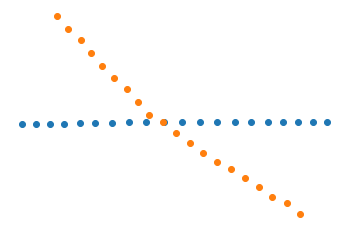

In [15]:
# Your turn!
# Pick one random complex preshape and visualize it with the Fréchet mean
random=np.random.choice(len(complex_preshapes)-1, size=1, replace=False)[0]
plt.scatter(mean_shape_Frechet.real,mean_shape_Frechet.imag)
plt.scatter(complex_preshapes[random].real,complex_preshapes[random].imag)
plt.axis('off')
plt.show()

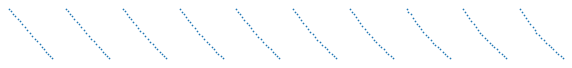

In [16]:
# Compute N steps along the geodesic path
steps=10
path=geodesicPath(mean_shape_Frechet,complex_preshapes[random],steps)

fig, ax = plt.subplots(1,steps, figsize=(steps,1))
for i in range(steps):
    ax[i].scatter(path[i].real,path[i].imag, s=.5)
    ax[i].axis('off')

**2.4** Compare the length of the above geodesics with the Procrustes distance (the distance you used for the alignment in 1.2). What do you observe? Can you relate that to what you know about the nature of the shape space?

In [17]:
# Your turn!
geo_distance=geodesicDistance(complex_preshapes[random],mean_shape_Frechet)
print("Geodesic distance: "+str(geo_distance))

reference=np.stack((mean_shape_Frechet.real,mean_shape_Frechet.imag),axis=1)
procrustes_dist=np.linalg.norm(aligned_shapes[random]-reference)
print("Procrustes distance: "+str(procrustes_dist))

Geodesic distance: 0.061121338218796555
Procrustes distance: 0.061111824571635866


### 3. Shape space PCA

A classical trick to perform local linear operations on a Riemannian manifold is to rely on local tangent spaces. The way into and out of the tangent space are the logarithm and exponential maps, respectively. Their expression for the shape space of point models we are currently working with are provided below.

In [18]:
def logarithmMap(z,w): 
    '''Computes a preshape pertaining to the equivalence class log_[z]([w]),
    where log is relative the shape space Sigma'''
    ta = np.angle(hermitianProduct(z,w))
    w_r = np.exp(-1j*ta)*w
    ro = geodesicDistance(z,w_r)
    return ro/np.sin(ro)*(w_r - np.cos(ro)*z)

def exponentialMap(z,v): 
    '''Computes the exponential of the tangent vector v in C^n at a preshape z'''
    t = np.sqrt(v.conj().T @ v).real
    if t < 1e-16 :
        return z
    return np.cos(t)*z + v*np.sin(t)/t

**3.1** The lines below perform PCA in the tangent plane around the Fréchet mean using the logarithmic and exponential maps appropriately and displays the explained variance. What does it tell you about the data? 

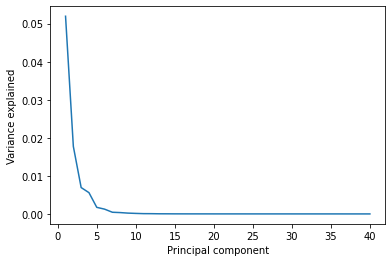

In [19]:
from sklearn.decomposition import PCA

tangent_vectors=np.zeros((complex_preshapes.shape[0],2*complex_preshapes.shape[1]))
for i in range(len(complex_preshapes)):
    tangent_vector=logarithmMap(mean_shape_Frechet, complex_preshapes[i])
    tangent_vectors[i,:N]=tangent_vector.real
    tangent_vectors[i,N:]=tangent_vector.imag

pca = PCA()
transformed_vectors = pca.fit_transform(tangent_vectors)

plt.plot(np.linspace(1,pca.n_components_,pca.n_components_),pca.explained_variance_)
plt.xlabel("Principal component")
plt.ylabel("Variance explained")
plt.show()

**3.2** The lines below retreive the K modes of shape variation and visualize them around the mean. What does it tell you about the shapes present in the data?

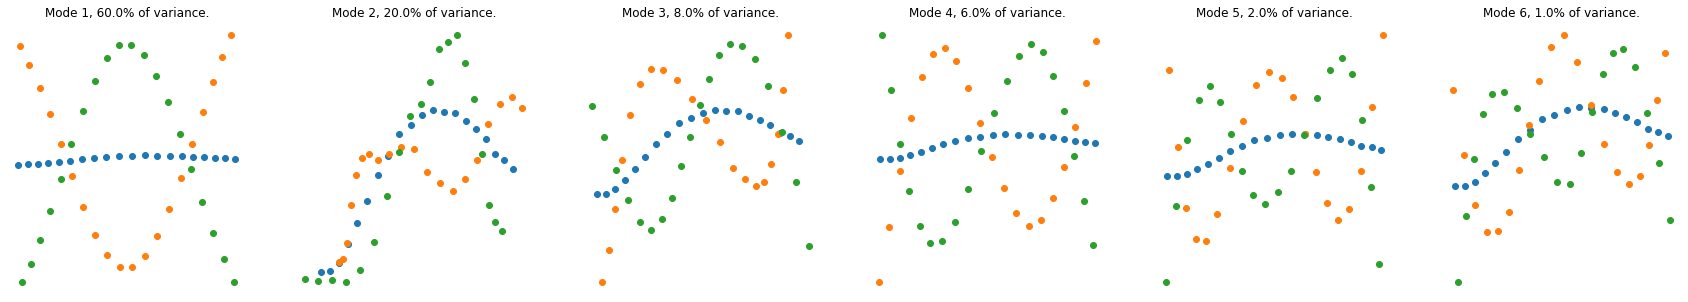

In [55]:
l=np.sqrt(pca.explained_variance_)
K=6

modes_shape=np.zeros((K,2,N),dtype=np.complex)
for i in range(K) :
    vector=np.zeros(pca.n_components_)
    vector[i]=1
    mode=l[i]*pca.inverse_transform(vector)
    complex_mode=mode[:N]+1j*mode[N:]
    modes_shape[i][0]=exponentialMap(mean_shape_Frechet, complex_mode)
    modes_shape[i][1]=exponentialMap(mean_shape_Frechet, -complex_mode)
    
fig, ax = plt.subplots(1, K, figsize=(5*K,5))
for i in range(K):
    ax[i].scatter(mean_shape_Frechet.real,mean_shape_Frechet.imag)
    ax[i].scatter(modes_shape[i][0].real, modes_shape[i][0].imag)
    ax[i].scatter(modes_shape[i][1].real, modes_shape[i][1].imag)
    ax[i].axis("off")
    
    percent_variance=np.round(100*l[i]**2/np.sum(pca.explained_variance_))
    ax[i].set_title("Mode "+str(i+1)+", "+str(percent_variance)+"% of variance.")

**3.3** The lines below plot the PCA-transformed data around the Fréchet mean. What does it tell you about the dataset?

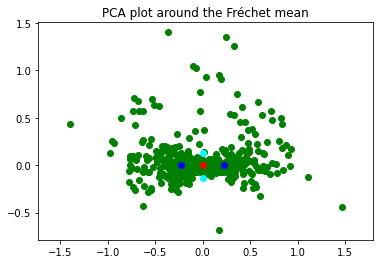

In [21]:
plt.scatter(transformed_vectors[:,0], transformed_vectors[:,1], c="g")
plt.scatter([0],[0], c="r")
plt.scatter([l[0],-l[0]], [0.,0.],c="blue")
plt.scatter([0.,0.],[l[1],-l[1]],c="cyan")
plt.axis("equal")
plt.title("PCA plot around the Fréchet mean")
plt.show()

**[BONUS] 3.4** Perform PCA as above but without using the logarithm and exponential maps. What do you see? Can you relate that to what you observed in 2.4?

In [ ]:
# Your turn!
flattened_aligned_shapes=np.zeros((aligned_shapes.shape[0],2*aligned_shapes.shape[1]))
for i in range(len(aligned_shapes)):
    flattened_aligned_shapes[i,:N]=aligned_shapes[i][:,0]
    flattened_aligned_shapes[i,N:]=aligned_shapes[i][:,0]
    
terribly_wrong_pca = PCA()
terribly_wrong_transformed_data = terribly_wrong_pca.fit_transform(flattened_aligned_shapes)

plt.plot(terribly_wrong_pca.explained_variance_)
plt.xlabel("Number of principal components")
plt.ylabel("Variance explained")
plt.show()

In [ ]:
terribly_wrong_l=np.sqrt(terribly_wrong_pca.explained_variance_)
K=6

terribly_wrong_modes_shape=np.zeros((K,N,2))
for i in range(K) :
    vector=np.zeros(terribly_wrong_pca.n_components_)
    vector[i]=1
    terribly_wrong_mode=0.25*terribly_wrong_l[i]*terribly_wrong_pca.inverse_transform(vector)
    terribly_wrong_modes_shape[i][:,0]=terribly_wrong_mode[:N]
    terribly_wrong_modes_shape[i][:,1]=terribly_wrong_mode[N:]
    
fig, ax = plt.subplots(1, K, figsize=(5*K,5))
for i in range(K):
    ax[i].scatter(mean_shape_Frechet.real,mean_shape_Frechet.imag)
    ax[i].scatter(terribly_wrong_modes_shape[i][:,0], terribly_wrong_modes_shape[i][:,1])
    ax[i].scatter(-terribly_wrong_modes_shape[i][:,0], -terribly_wrong_modes_shape[i][:,1])
    ax[i].axis("off")
    
    percent_variance=np.round(100*terribly_wrong_l[i]**2/np.sum(terribly_wrong_pca.explained_variance_))
    ax[i].set_title("Mode "+str(i+1)+", "+str(percent_variance)+"% of variance.")

### 4. Statistical shape modelling

**4.1** The following lines generate synthetic shapes relying on a simple statistical model (multivariate Gaussian) built from the covariance matrix of the dataset. Do you understand how the model is constructed? How good do you think this model is and why?

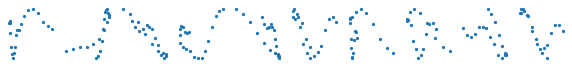

In [102]:
import scipy.stats

num_synthetic_data=10
count=2

synthetic_data=np.zeros((num_synthetic_data,N),dtype=np.complex)
for i in range(num_synthetic_data):
    rand=[]
    for k in range(pca.n_components_):
        var=pca.explained_variance_[k]*(len(tangent_vectors)-1)
        if var<1e-6:
            sigma=0.0
        else:
            sigma=np.sqrt(var)
        rand.append(scipy.stats.norm.rvs(loc=0, scale=sigma, size=1))
    rand=np.array(rand)

    v=np.zeros((pca.n_components_))
    for k in range(count):
        zz=rand.T @ pca.components_.T[:,k]
        v+=(zz*pca.components_.T[:,k])+pca.mean_
    
    complex_v=v[:N]+1j*v[N:]
    synthetic_data[i]=exponentialMap(mean_shape_Frechet, complex_v) 
    
fig, ax = plt.subplots(1, num_synthetic_data, figsize=(num_synthetic_data,1))
for i in range(num_synthetic_data):
    ax[i].scatter(synthetic_data[i].real, synthetic_data[i].imag, s=5)
    ax[i].axis("off")

### 5. Dictionary learning